# PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d
import os
from sklearn.neighbors import KNeighborsClassifier

### Choosing 25 subjects from 68 in the CMU PIE dataset

In [2]:
PIE_subjects = os.listdir("PIE")
selected_subjects = np.random.choice(PIE_subjects, size = 25, replace = False)
train_photos_path = []
test_photos_path  = []
for subject in selected_subjects:
    subject_photos = os.listdir("PIE"+"/"+subject)
    subject_train  = np.random.choice(subject_photos, size = int(0.7*len(subject_photos)), replace=False)
    subject_test   = np.setdiff1d(subject_photos, subject_train)
    for photo in subject_train :
        train_photos_path.append("PIE"+'/'+subject+'/'+photo)
    for photo in subject_test :
        test_photos_path.append("PIE"+'/'+subject+'/'+photo)

train_photos_array =  np.array([plt.imread(photo) for photo in train_photos_path])
test_photos_array =  np.array([plt.imread(photo) for photo in test_photos_path])
print("The selected subjects are :\n", selected_subjects)

The selected subjects are :
 ['48' '14' '54' '10' '2' '19' '67' '49' '9' '15' '41' '37' '39' '29' '16'
 '68' '35' '51' '56' '5' '52' '3' '34' '44' '20']


### reading my selfies

In [3]:
selfies = os.listdir("selfies")
selfies_path = []
for selfie in selfies :
    selfies_path.append("selfies" + '/' + selfie)
train_selfies_path = np.random.choice(selfies_path, size = 7, replace=False)
test_selfies_path  = np.setdiff1d(selfies_path, train_selfies_path)

#train_selfies_array = np.array([plt.imread(selfie) for selfie in train_selfies_name])
#test_selfies_array = np.array([plt.imread(selfie) for selfie in test_selfies_name])

In [4]:
X_train_selfies = np.array([plt.imread(selfie) for selfie in train_selfies_path])
X_test_selfies  = np.array([plt.imread(selfie) for selfie in test_selfies_path])

Y_train_selfies = np.array([69 for i in range(7)])
Y_test_selfies  = np.array([69 for i in range(3)])

### Selecting 500 photos randomly

In [5]:
selected_train_photos_path = np.random.choice(train_photos_path, size=500, replace=False)
X_train_500 = np.array([plt.imread(photo) for photo in selected_train_photos_path])

In [6]:
_, img_size1, img_size2 = X_train_500.shape
num_features = img_size1*img_size2

In [7]:
# Adding the selfies
X_train_500 = np.concatenate((X_train_500, X_train_selfies), axis=0)
X_train_500 = X_train_500.reshape((507, num_features))

### Applying PCA

In [8]:
def PCA(data):
    data_centered = data - np.mean(data, axis=0)
    cov_m = np.cov(data_centered.T)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_m)
    # find the indexes of the highest eignevalues
    eigen_vals_indexes = np.argsort(abs(eigen_vals))[::-1]
    # sort the eigen values and vectors accordinly
    sorted_eigen_vals      = eigen_vals[eigen_vals_indexes]
    sorted_eigen_vecs      = eigen_vecs[:,eigen_vals_indexes]
    return sorted_eigen_vals, sorted_eigen_vecs

In [9]:
eigen_vals, eigen_vecs = PCA(X_train_500)

### reducing dim to 2 and 3

In [10]:
reduced_2D_data = np.dot(X_train_500-np.mean(X_train_500,axis=0), eigen_vecs[:,:2])
reduced_3D_data = np.dot(X_train_500-np.mean(X_train_500,axis=0), eigen_vecs[:,:3])

### 2D visualisation

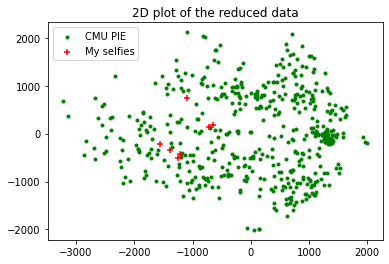

In [11]:
plt.scatter(reduced_2D_data[:-7,0].real, reduced_2D_data[:-7,1].real, marker='.', color = 'g', label="CMU PIE" )
plt.scatter(reduced_2D_data[-7:,0].real, reduced_2D_data[-7:,1].real, marker='+', color = 'r', label="My selfies" )
plt.title("2D plot of the reduced data")
plt.legend()
plt.show()

### 3D visualisation

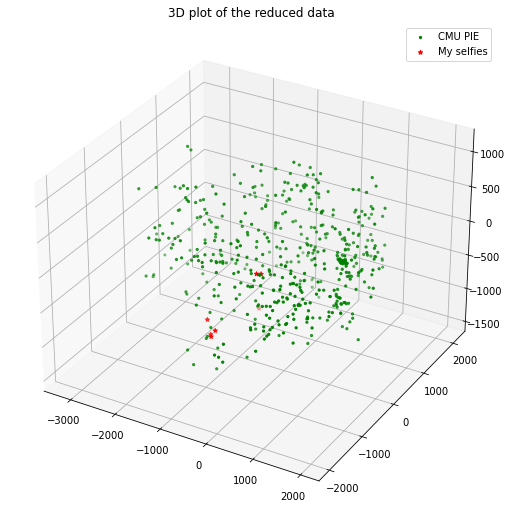

In [12]:
fig = plt.figure(figsize=(9,9))
ax  = fig.add_subplot(projection="3d")
PIE_x     = reduced_3D_data[:-7, 0].real
PIE_y     = reduced_3D_data[:-7, 1].real
PIE_z     = reduced_3D_data[:-7, 2].real
selfies_x = reduced_3D_data[-7:, 0].real
selfies_y = reduced_3D_data[-7:, 1].real
selfies_z = reduced_3D_data[-7:, 2].real 

ax.scatter3D(PIE_x, PIE_y, PIE_z, marker = '.',color = 'g', label="CMU PIE")
ax.scatter3D(selfies_x, selfies_y, selfies_z, marker = '*',color='r', label="My selfies")
ax.set_title("3D plot of the reduced data")
plt.legend()
plt.show()

### plot of the three eigenfaces

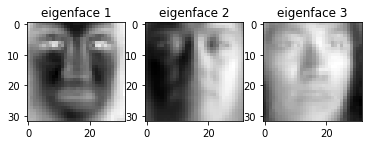

In [13]:
fig=plt.figure()
for i in range(3):
    eig_face = eigen_vecs[:,i].real.reshape([img_size1,img_size2])
    ax = fig.add_subplot(1, 3, i+1)
    ax.title.set_text('eigenface '+str(i+1))
    plt.imshow(eig_face,cmap='gray')
plt.show()

## Classifying the test images using the nearest neighbor

In [14]:
# Update Xtrain, Ytrain, Xtest, Ytest to include all the data
X_train = train_photos_array
Y_train = np.array([path.split('/')[-2] for path in train_photos_path])
X_test  = test_photos_array
Y_test  = np.array([path.split('/')[-2] for path in test_photos_path])

In [15]:
# Add the selfies
X_train = np.concatenate((X_train, X_train_selfies), axis=0).reshape((len(X_train)+7, num_features))
X_test  = np.concatenate((X_test, X_test_selfies), axis=0).reshape((len(X_test)+3, num_features))
Y_train = np.concatenate((Y_train, Y_train_selfies), axis=0)
Y_test  = np.concatenate((Y_test, Y_test_selfies), axis=0)

In [16]:
# Apply PCA to the train set
train_eigen_vals, train_eigen_vecs = PCA(X_train)

In [17]:
for d in [40, 80, 200] :
    print("Dim : ", d)
    # Reduce the training data dimentionality
    reduced_X_train = np.dot(X_train-np.mean(X_train,axis=0), train_eigen_vecs[:,:d]).real
    # Reduce the test data dimentionality
    reduced_X_test = np.dot(X_test-np.mean(X_test,axis=0), train_eigen_vecs[:,:d]).real
    # Initialize a KNN classifier with K=1
    knn = KNeighborsClassifier(n_neighbors = 1)
    # Train the model
    knn.fit(reduced_X_train, Y_train)
    # Compute the predicted label of the test data
    Y_pred = knn.predict(reduced_X_test)
    # Compute the test score 
    score_CMU = (np.sum(Y_test[:-3] == Y_pred[:-3]))/(len(Y_test))
    score_selfie = (np.sum(Y_test[-3:] == Y_pred[-3:]))/3
    print("Score of the test set :")
    print("CMU PIE : {}, Selfies : {}".format(score_CMU, score_selfie))

Dim :  40
Score of the test set :
CMU PIE : 0.9186492709132771, Selfies : 1.0
Dim :  80
Score of the test set :
CMU PIE : 0.9409056024558711, Selfies : 1.0
Dim :  200
Score of the test set :
CMU PIE : 0.9516500383729855, Selfies : 1.0
